In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_TST.model.TST import PatchTST_backbone
from torch.utils.data import Dataset, DataLoader
from torch_TST.layer.data_get import TSDataset
from torch_TST.layer.utils import masked_mape_loss,r2_score,EarlyStopCallback,plot_learning_curves,plot_list
from torch.optim import Adam
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
data_features_dict = {
    "ELBSL4-12570S机组系统_L4-125S压缩机组_01#压缩机_压缩机1能级状态": "cpr1",
    "ELBSL4-12570S机组系统_L4-125S压缩机组_02#压缩机_压缩机2能级状态": "cpr2",
    "ELBSL4-12570S机组系统_L4-125S压缩机组_03#压缩机_压缩机3能级状态": "cpr3",
    "ELBSL4-12570S机组系统_L4-70S压缩机组_04#压缩机_压缩机4能级状态": "cpr4",
    "ELBSL4-12570S机组系统_L4冷凝设备组_01#水泵_蒸发冷水泵": "cdr_pump",
    "ELBSL4-12570S机组系统_L4冷凝设备组_01#风机_蒸发冷风机1": "cdr_fan1",
    "ELBSL4-12570S机组系统_L4冷凝设备组_02#风机_蒸发冷风机2": "cdr_fan2",
    "ELBSL4-12570S机组系统_L4冷凝设备组_03#风机_蒸发冷风机3": "cdr_fan3",
    "ELBSL4-12570S机组系统_L4-125S压缩机组_冷冻吸气压力": "in_pa",
    "ELBSL4-12570S机组系统_L4-125S压缩机组_冷冻吸气温度": "in_temp",
    "ELBSL4-12570S机组系统_L4-125S压缩机组_排气压力": "ex_pa",
    "ELBSL4-12570S机组系统_L4-125S压缩机组_供液温度": "liq_temp",
    "ELBSL4-12570S机组系统_L4-125S压缩机组_排气温度": "ex_temp",
    "ELBSL4-12570S机组系统_L4-125S压缩机组_环境温度": "env_temp",
    "3#冷冻库_01#风机_风机状态": "fre3_fan1",
    "冷藏库_01#风机_风机状态": "refr_fan",
    "1#冷冻库_01#风机_风机状态": "fre1_fan1",
    "2#冷冻库_01#风机_风机状态": "fre2_fan1",
    "3#冷冻库_02#风机_风机状态": "fre3_fan2",
    "冷藏库_02#风机_风机状态": "refr_fan2",
    "1#冷冻库_02#风机_风机状态": "fre1_fan2",
    "2#冷冻库_02#风机_风机状态": "fre2_fan2",
    "月台_01#02#风机_风机状态": "pf_fan12",
    "1#冷冻库_03#风机_风机状态": "fre1_fan3",
    "2#冷冻库_03#风机_风机状态": "fre2_fan3",
    "3#冷冻库_03#风机_风机状态": "fre3_fan3",
    "月台_03#04#风机_风机状态": "pf_fan34",
    "3#冷冻库_04#风机_风机状态": "fre3_fan4",
    "1#冷冻库_04#风机_风机状态": "fre1_fan4",
    "2#冷冻库_04#风机_风机状态": "fre2_fan4",
    "1#冷冻库_05#风机_风机状态": "fre1_fan5",
    "月台_05#06#风机_风机状态": "pf_fan56",
    "1#冷冻库_06#风机_风机状态": "fre1_fan6",
    "1#冷冻库_冷冻1_传感器1温度": "fre1_temp1",
    "1#冷冻库_冷冻1_传感器2温度": "fre1_temp2",
    "1#冷冻库_冷冻1_传感器3温度": "fre1_temp3",
    "1#冷冻库_冷冻1_传感器4温度": "fre1_temp4",
    "1#冷冻库_冷冻1_传感器5温度": "fre1_temp5",
    "1#冷冻库_冷冻1_传感器6温度": "fre1_temp6",
    "1#冷冻库_冷冻1_平均温度": "fre1_temp_avg",
    "2#冷冻库_冷冻库2门1_冷冻库2门1": "fre2_door1",
    "2#冷冻库_冷冻库2门2_冷冻库2门2": "fre2_door2",
    "2#冷冻库_冷冻库2门3_冷冻库2门3": "fre2_door3",
    "2#冷冻库_冷冻2_传感器1温度": "fre2_temp1",
    "2#冷冻库_冷冻2_传感器2温度": "fre2_temp2",
    "2#冷冻库_冷冻2_传感器3温度": "fre2_temp3",
    "2#冷冻库_冷冻2_传感器4温度": "fre2_temp4",
    "2#冷冻库_冷冻2_平均温度": "fre2_temp_avg",
    "3#冷冻库_冷冻3_传感器1温度": "fre3_temp1",
    "3#冷冻库_冷冻3_传感器2温度": "fre3_temp2",
    "3#冷冻库_冷冻3_传感器3温度": "fre3_temp3",
    "3#冷冻库_冷冻3_传感器4温度": "fre3_temp4",
    "3#冷冻库_冷冻3_平均温度": "fre3_temp_avg",
    "ELBSL4-12570S机组系统_其他_L4机组电表_L4机组_Psum": "kw",
    "1#冷冻库_冷冻1_温度设定上限": "fre1_temp_up",
    "1#冷冻库_冷冻1_温度设定下限": "fre1_temp_low",
    "2#冷冻库_冷冻2_温度设定上限": "fre2_temp_up",
    "2#冷冻库_冷冻2_温度设定下限": "fre2_temp_low",
    "3#冷冻库_冷冻3_温度设定上限": "fre3_temp_up",
    "3#冷冻库_冷冻3_温度设定下限": "fre3_temp_low"
}
features = [
    'ELBSL4-12570S机组系统_其他_L4机组电表_L4机组_Psum',
    'ELBSL4-12570S机组系统_L4冷凝设备组_01#水泵_蒸发冷水泵',
    'ELBSL4-12570S机组系统_L4冷凝设备组_01#风机_蒸发冷风机1',
    '1#冷冻库_05#风机_风机状态',
    'ELBSL4-12570S机组系统_L4-125S压缩机组_03#压缩机_压缩机3能级状态',
    'ELBSL4-12570S机组系统_L4-125S压缩机组_01#压缩机_压缩机1能级状态',
    '1#冷冻库_03#风机_风机状态',
    'ELBSL4-12570S机组系统_L4-125S压缩机组_02#压缩机_压缩机2能级状态',
]
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
features_code =[] # 特征的字母表示
for feature in features:
    features_code.append(data_features_dict[feature])
df = pd.read_csv(r"../data/data_wh1_1hour.csv", index_col=0, parse_dates=['time'])
def add_time_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    return df
features_code.append('hour')
features_code.append('day_of_week')
features_code.append('day_of_month')
features_code.append('month')
df = add_time_features(df)

数据准备

In [5]:
train_len = int(df.shape[0]*0.8)
test_len = df.shape[0]-train_len
train_df= df[:train_len]
test_df = df[-test_len:]
c_in = df.shape[1]
input_len = 7*24
output_len  = 1*24

In [6]:
train_set = TSDataset(train_df, input_len=input_len, output_len=output_len,CI=c_in)
test_set = TSDataset(test_df, input_len=input_len, output_len=output_len,CI=c_in)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
# for inputs, outputs in train_loader:
#     inputs = inputs.permute(0,2,1)
#     outputs = outputs.permute(0,2,1)
#     print(inputs.shape, outputs.shape)
#     break

In [7]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct=None):
    loss_list = []
    # perdict_list = []
    for x,labes in dataloader:
        x = x.to(device)
        x = x.permute(0,2,1)
        labes = labes.to(device)
        perdicts = model(x).to(device)
        perdicts = perdicts.permute(0,2,1)
        perdicts = perdicts[:,:,0]
        labes = labes[:,:,0]
        if loss_fct is not None:
            loss = loss_fct(perdicts,labes)         # 验证集损失
        else:
            loss = masked_mape_loss(perdicts,labes)
        loss_list.append(loss.cpu().item())
        # labels_1d = labes.view(-1)
        # perdict = perdicts[:,0,:]
        # p = perdict.view(-1)
        # perdict_list.append(p.cpu().item())

    return np.mean(loss_list)

In [8]:
@torch.no_grad()
def predict_tstbackbone(model, dataloader):
    perdict_list = []
    for x,labes in dataloader:
        x = x.to(device)
        x = x.permute(0,2,1)
        perdicts = model(x).to(device)
        perdicts = perdicts.permute(0,2,1)
        perdicts = perdicts[:,:,0]
        p = perdicts.squeeze(1)
        perdict_list.append(p)
    return perdict_list

In [9]:
# tgt_mask = torch.tril(torch.ones(tgt.size(1), tgt.size(1)), diagonal=0) == 0
# 训练
from tqdm.auto import tqdm
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    scheduler=None,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    global_step = 1
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for x,y in train_loader:
                x = x.to(device)
                y = y.to(device)
                # 梯度清空
                x = x.permute(0,2,1)
                # y = y.permute(0,2,1)
                optimizer.zero_grad()
                # 前向计算
                pedicts = model(x)
                pedicts =pedicts.permute(0,2,1)
                pedicts = pedicts[:,:,0].unsqueeze(-1)
                loss = loss_fct(pedicts,y)

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()
                if scheduler is not None:
                    scheduler.step() # 更新学习率

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    # model.eval()
                    # val_loss = evaluating(model, val_loader, loss_fct)
                    # record_dict["val"].append({
                    #     "loss": val_loss, "step": global_step
                    # })
                    # model.train()

                    # 1. 使用 tensorboard 可视化
                    # cur_lr = optimizer.param_groups[0]["lr"] if scheduler is None else scheduler.get_last_lr()[0]
                    # if tensorboard_callback is not None:
                    #     tensorboard_callback(
                    #         global_step,
                    #         loss=loss, val_loss=val_loss,
                    #         lr=cur_lr,
                    #         )
                    #
                    # # 2. 保存模型权重 save model checkpoint
                    # if save_ckpt_callback is not None:
                    #     save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


In [10]:

class TsLstm(nn.Module):
    def __init__(self,c_in,context_window,target_window,ls_hd,Lstm_layernums,output_size = 1):
        super(TsLstm,self).__init__()
        self.Ts = PatchTST_backbone(c_in=c_in,context_window=context_window,target_window=target_window,patch_len=target_window,stride=target_window)
        self.Ls = nn.LSTM(input_size=c_in,hidden_size=ls_hd,num_layers=Lstm_layernums,batch_first=True)
        self.ol = nn.Linear(ls_hd,output_size)
    def forward(self,x):
        x = self.Ts(x)  #x:[bs,c_cin,target_window]
        x = x.permute(0,2,1)
        x,_ = self.Ls(x)

        # x = self.ol(x)
        return x

In [11]:
model = TsLstm(c_in=c_in,context_window=input_len,target_window=output_len,ls_hd=1,Lstm_layernums=1).to(device)

In [12]:
patch_len = 24
model = PatchTST_backbone(c_in=c_in,context_window=input_len,target_window=output_len,patch_len=patch_len,stride=8).to(device)

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer  = SummaryWriter()
x = torch.rand(32,c_in,input_len).to(device)
writer.add_graph(model,x)
writer.close()

KeyboardInterrupt: 

In [7]:
x.device == next(model.parameters()).device

True

In [13]:
x = torch.rand(32,c_in,input_len).to(device)
y = model(x)
y.shape

torch.Size([32, 12, 24])

In [10]:
all_on_same_device = all(param.device == next(model.parameters()).device for param in model.parameters())
if all_on_same_device:
    print("所有参数都在同一设备上:", next(model.parameters()).device)
else:
    print("模型中的参数不在同一设备上")

所有参数都在同一设备上: cuda:0


In [14]:
early_stop = EarlyStopCallback()
optimizer = Adam(params=model.parameters(), lr=1e-5, weight_decay=5e-4, eps=5e-9)
loss = nn.MSELoss()

In [15]:
record = training(model=model,train_loader=train_loader,val_loader=test_loader,
                  epoch=40,loss_fct=loss,optimizer=optimizer)

  0%|          | 0/8200 [00:00<?, ?it/s]

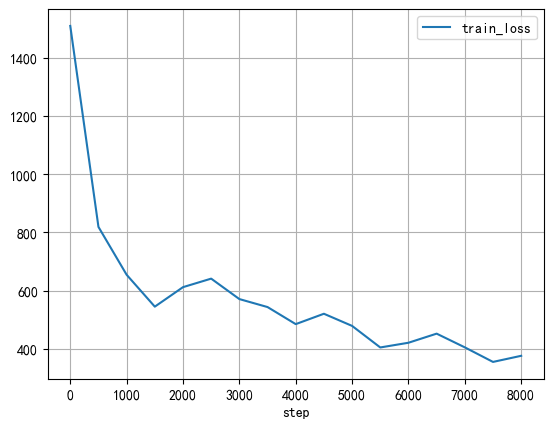

In [16]:
plot_learning_curves(record)

In [13]:
record

{'train': [{'loss': 1324.433837890625, 'step': 1},
  {'loss': 1965.180419921875, 'step': 2},
  {'loss': 2140.61083984375, 'step': 3},
  {'loss': 1141.160400390625, 'step': 4},
  {'loss': 2638.469970703125, 'step': 5},
  {'loss': 1868.41796875, 'step': 6},
  {'loss': 1555.373046875, 'step': 7},
  {'loss': 1211.54541015625, 'step': 8},
  {'loss': 1133.415771484375, 'step': 9},
  {'loss': 1753.60546875, 'step': 10},
  {'loss': 3083.2333984375, 'step': 11},
  {'loss': 1711.4974365234375, 'step': 12},
  {'loss': 1927.8636474609375, 'step': 13},
  {'loss': 2118.4853515625, 'step': 14},
  {'loss': 3337.082763671875, 'step': 15},
  {'loss': 1144.7259521484375, 'step': 16},
  {'loss': 1162.849853515625, 'step': 17},
  {'loss': 1177.119140625, 'step': 18},
  {'loss': 1383.3173828125, 'step': 19},
  {'loss': 1462.9407958984375, 'step': 20},
  {'loss': 1382.2255859375, 'step': 21},
  {'loss': 1730.138671875, 'step': 22},
  {'loss': 1847.7572021484375, 'step': 23},
  {'loss': 1447.741455078125, 'st

In [30]:
perdict_tstbackbone = predict_tstbackbone(model,test_loader)

In [48]:
perdict = []
for i in perdict_tstbackbone:
    perdict.append(i[0][0].item())

In [49]:
perdict

[85.28195190429688,
 89.44975280761719,
 101.96258544921875,
 94.54751586914062,
 91.75225830078125,
 135.26722717285156,
 107.32781982421875,
 111.76966857910156,
 98.29817199707031,
 70.25123596191406,
 98.76488494873047,
 105.07838439941406,
 108.70167541503906,
 103.87523651123047,
 103.61547088623047,
 65.63574981689453,
 59.336830139160156,
 58.21788024902344,
 58.6912727355957,
 54.36980056762695,
 73.1185302734375,
 64.92568969726562,
 74.52336120605469,
 87.302978515625,
 87.4073486328125,
 82.7763900756836,
 121.72557830810547,
 96.89798736572266,
 107.38398742675781,
 109.6330795288086,
 98.62745666503906,
 90.40766906738281,
 87.69515228271484,
 84.96672058105469,
 101.91458129882812,
 100.75860595703125,
 110.81268310546875,
 105.91058349609375,
 103.22367095947266,
 69.53750610351562,
 64.85780334472656,
 67.24915313720703,
 76.6086196899414,
 74.22728729248047,
 88.67684936523438,
 75.597412109375,
 103.34867095947266,
 66.06776428222656,
 68.4291000366211,
 99.723510742

In [31]:
perdict_tstbackbone[0].shape

torch.Size([1, 24])

In [25]:
label = test_df.iloc[:,0]
len(label)

1683

In [58]:
y = []
for i in label:
    y.append(i)

In [60]:
def show_labelperdict(label,predict):
    # 绘制图表
    plt.figure(figsize=(20, 8))
    plt.plot(label, label='True Values (label)',color='blue')  # 折线图表示真实值
    plt.plot(predict, label='Predicted Values (predict)', color='red')  # 折线图表示预测值

    # 添加标题和标签
    plt.title('True vs Predicted Values', fontsize=14)
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Values', fontsize=12)

    # 添加图例
    plt.legend(fontsize=12)

    # 显示图表
    plt.grid()
    plt.show()

In [64]:
len(y[191:]) == len(perdict)

True

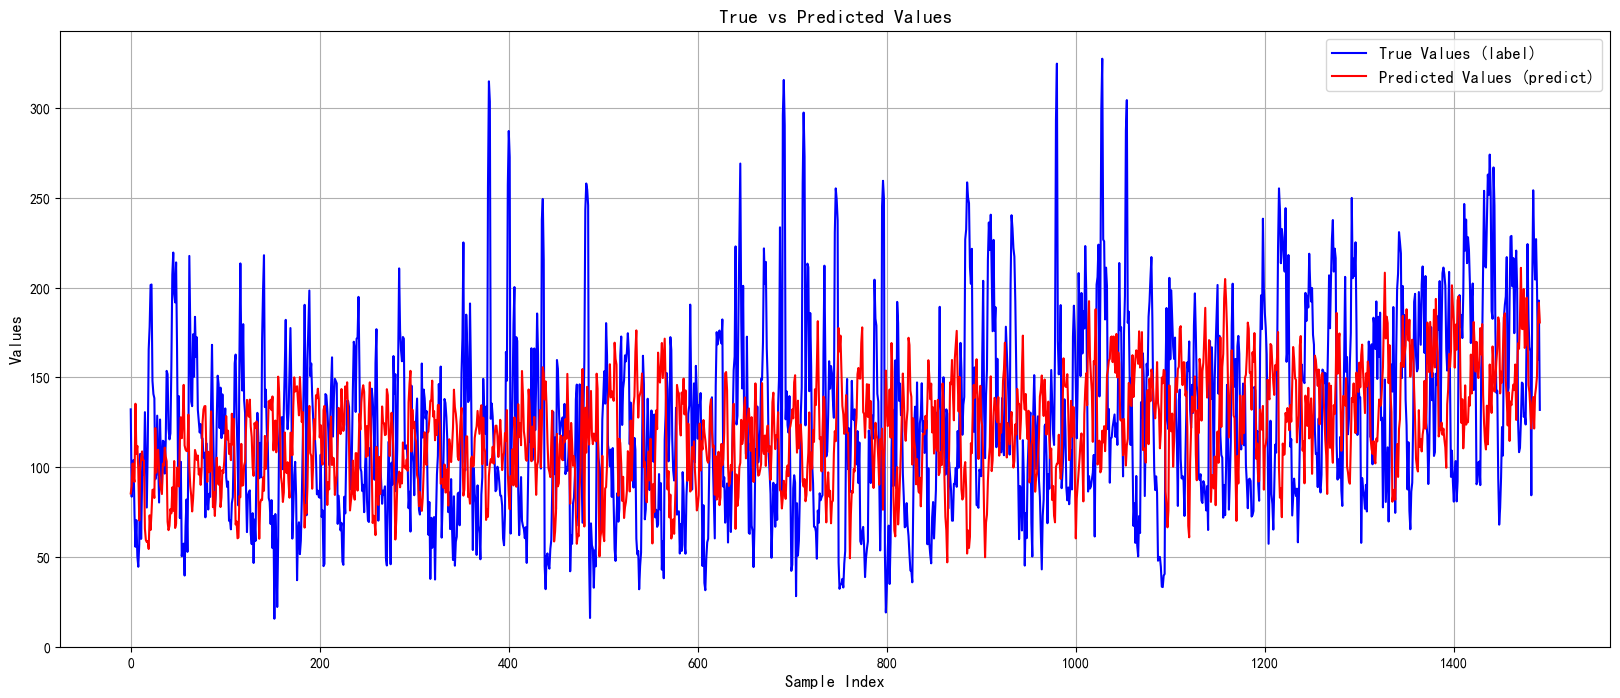

In [65]:
show_labelperdict(y[191:],perdict)

In [16]:
model.eval()
loss = evaluating(model, test_loader)
print(f"loss:     {loss:.4f}")

loss:     25.8636


In [1]:
import torch
from sklearn.metrics import r2_score as r2a

-0.008000000000000007